- К вам приходит руководитель продукта “Интернет-магазин”
- И спрашивает про удержание клиентов и повторные покупки
- У него есть опасение, что из-за проблем с доставкой товаров в магазине у нас   стали больше оттекать пользователи
- Он просит вас сравнить, на сколько сейчас все хуже, чем в прошлом году?   


Есть транзакции (покупки) в интернет магазине, в том числе id клиента, id покупки, timestamp покупки и тп
orders.csv, customers.csv  

Ваши задачи: 

- Проверить гипотезу руководителя продукта 
- Дать руководителю продукта инструмент для самостоятельного принятия решений по качеству удержания пользовательской базы

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from typing import List

from warnings import filterwarnings
filterwarnings(action='ignore')

In [2]:
orders = pd.read_csv('orders.csv', parse_dates=['order_date'])

In [3]:
orders.head(3)

,id,order_date,ship_mode,customer_id,sales
0,100006,2014-09-07,Standard,DK-13375,377.970
1,100090,2014-07-08,Standard,EB-13705,699.192
2,100293,2014-03-14,Standard,NF-18475,91.056


In [4]:
first_occurence = orders.groupby('customer_id')['order_date'].min().sort_values()
orders_occurence_year = orders.merge(right=first_occurence, on='customer_id')
# orders_occurence_year.sort_values(by='order_date_x', ascending=False)[:5]

In [5]:
first_occurence = orders.groupby('customer_id')['order_date'].min().sort_values()

In [6]:
def get_pivot(years: List):
    """
    return:
        res: List. List of pd.DataFrames - pivot tables
    """
    res = []
    for year in years:
        first_occurence_year = first_occurence[first_occurence.dt.year==year].dt.month.reset_index().rename(columns={'order_date':'Cohort month'})
        orders_year = orders[orders.order_date.dt.year==year][['customer_id', 'order_date']]
        orders_year.order_date = orders_year.order_date.dt.month
        orders_occurence_year = orders_year.merge(right=first_occurence_year, on='customer_id')[['order_date', 'Cohort month']]
        pivot_year = pd.pivot_table(orders_occurence_year, values='order_date', index='Cohort month', columns=['order_date'], aggfunc='size').fillna(0)
        pivot_year = pivot_year.reindex(range(1,13), axis='index').reindex(range(1,13), axis='columns', fill_value=0.0).fillna(0.0)
        res.append(pivot_year)
    return res

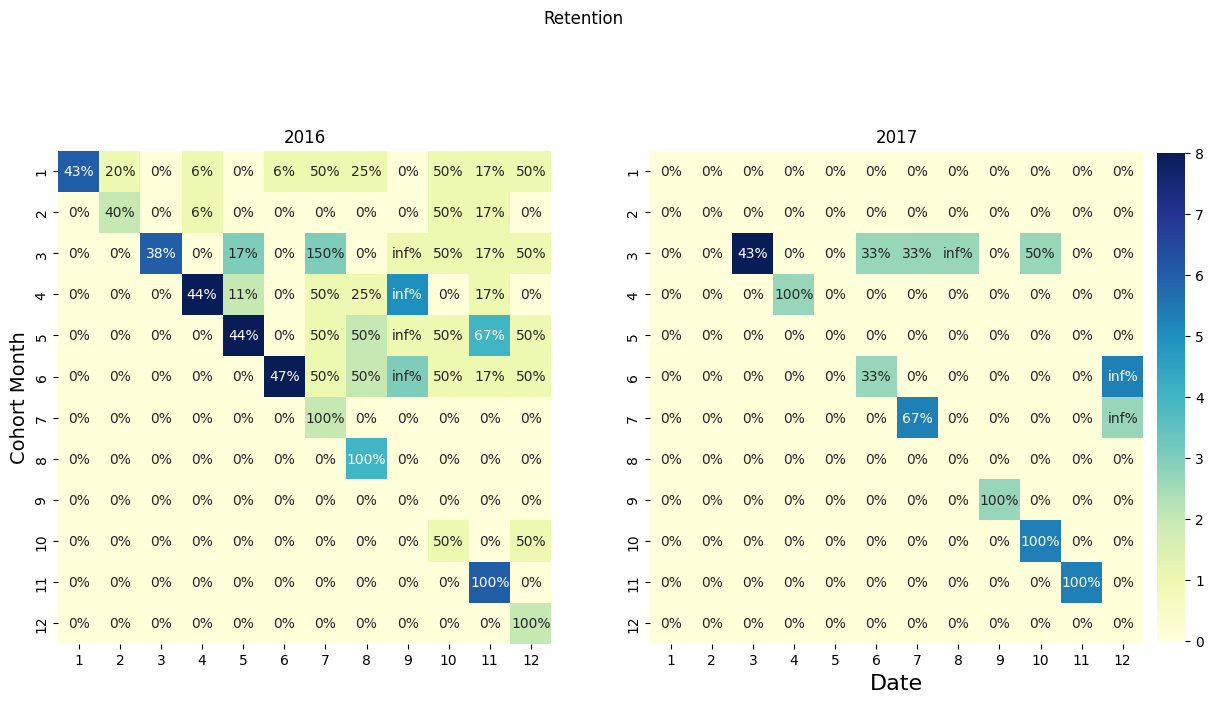

In [7]:
years = [2016, 2017]
pivots = get_pivot(years=years)
n = len(years)

fig, axn = plt.subplots(1, n, sharex=True, sharey=False, figsize=(14, 8))
cbar_ax = fig.add_axes([.91, 0.19, .02, .61])

plt.suptitle(f'Retention')
for i, ax in enumerate(axn.flat):
    ax.set_title(years[i])
    sns.heatmap((pivots[i]).fillna(0), 
                annot=(pivots[i] / pivots[i].sum(axis=1)).fillna(0),
                fmt='.0%',
                cmap="YlGnBu",
                ax=ax,
                cbar=i == 0,
                cbar_ax=None if i else cbar_ax,
                square=True,
               )
    
    y_name = 'Cohort Month' if i == 0 else ''
    ax.set_ylabel(y_name, fontsize=14)
    
    x_name = 'Date' if i == n//2 else ''
    ax.set_xlabel(x_name, fontsize=16)

plt.show()

В целом, действительно похоже, что ретеншн немного уменьшился, однако точно сказать сложно, так как данных в новом году гораздо меньше.